In [1]:
import numpy as np
import scipy as sc
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline
import json
import seaborn as sns

plt.rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'retina'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 22
cmap = sns.light_palette((210, 90, 60), 10, input="husl", reverse=True)

from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import MultiTaskElasticNet, MultiTaskElasticNetCV
from sklearn.linear_model import MultiTaskLasso, MultiTaskLassoCV

from qpfs import get_corr_matrix, shift_spectrum, QPFS, MultivariateQPFS

lr = LinearRegression()
mten = MultiTaskElasticNet(alpha=0.1)
mtlasso = MultiTaskLasso(alpha=0.1)

In [2]:
def RMSE(Y, P):
    return np.sqrt(np.mean((Y - P) ** 2))


def metric_vif(active_idxs):
    with open('res/ecog_vifx.json', 'r') as f:
        vifx = np.array(json.loads(f.read()))[active_idxs]
    return np.max(vifx)


def metric_stability(X):
    ev = np.linalg.eigh(X.T.dot(X))[0]
    return np.log(ev[0] / ev[-1])


def metric_rmse(X, Y, est=None):
    if est is None:
        est = LinearRegression()
        est.fit(X, Y)
    Y_pred = est.predict(X)
    return np.mean(np.sqrt(np.mean((Y - Y_pred) ** 2, axis=0)))


def metric_nmse(X, Y, est=None):
    if est is None:
        est = LinearRegression()
        est.fit(X, Y)
    Y_pred = est.predict(X)
    Y_base = Y.mean(axis=0)
    return np.mean(np.sqrt(np.mean((Y - Y_pred) ** 2, axis=0)) / np.sqrt(np.mean((Y - Y_base) ** 2, axis=0)))


def metric_bic(X, Y, est=None):
    if est is None:
        est = LinearRegression()
        est.fit(X, Y)
    Y_pred = est.predict(X)
    m, p = X.shape
    return np.mean(np.log(np.mean((Y - Y_pred) ** 2, axis=0))) + p * np.log(m) / m


def metric_aic(X, Y, est=None):
    if est is None:
        est = LinearRegression()
        est.fit(X, Y)
    Y_pred = est.predict(X)
    m, p = X.shape
    return np.mean(np.log(np.mean((Y - Y_pred) ** 2, axis=0))) + 2 * p / m


def metric_corr(Q, b, active_idxs):
    b = b[active_idxs]
    Q = Q[active_idxs][:, active_idxs]
    return b.T.dot(np.linalg.pinv(Q)).dot(b)

In [3]:
def get_autoreg_Y(Y, step=1):
    m, t = Y.shape
    ar = np.zeros((m - step + 1, t * step))
    for i in range(step):
        for k in range(t):
            ar[:, i * t + k] = Y[i: m + i - step + 1, k]

    return ar


def get_bootstrap(X, Y):
    n = X.shape[0]
    idxs = np.random.choice(np.arange(n), size=n)
    return X[idxs], Y[idxs]

In [4]:
def get_metrics(n_active_array, modes, score_history, Xtrain, Ytrain, Xtest, Ytest):
    results = {}
    results['score'] = []
    results['train_rmse'] =[]
    results['test_rmse'] = []
    results['stability'] = []
    results['vif'] = []
    results['aic'] = []
    results['bic'] = []
    results['corr'] = []
    results['modes'] = modes
    results['n_active_array'] = n_active_array.tolist()
    
    Q = get_corr_matrix(Xtrain)
    B = get_corr_matrix(Xtrain, Ytrain)
    
    for score in tqdm_notebook(score_history, leave=False):
        idxs_sort = score.argsort()[::-1]

        train_rmse = []
        test_rmse = []
        train_rmse_pls = []
        test_rmse_pls = []
        stability = []
        vif = []
        bic = []
        aic = []
        corr = []

        for k in tqdm_notebook(n_active_array, leave=False):
            active_idxs = idxs_sort[:k]
            lr.fit(Xtrain[:, active_idxs], Ytrain)
            train_rmse.append(metric_nmse(Xtrain[:, active_idxs], Ytrain, lr))
            test_rmse.append(metric_nmse(Xtest[:, active_idxs], Ytest, lr))
            stability.append(metric_stability(Xtrain[:, active_idxs]))
            vif.append(metric_vif(active_idxs))
            bic.append(metric_bic(Xtrain[:, active_idxs], Ytrain, lr))
            aic.append(metric_aic(Xtrain[:, active_idxs], Ytrain, lr))
            corr.append(np.mean(np.diag(metric_corr(Q, B, active_idxs))))

        results['score'].append(score[idxs_sort].tolist())
        results['train_rmse'].append(train_rmse)
        results['test_rmse'].append(test_rmse)
        results['stability'].append(stability)
        results['vif'].append(vif)
        results['bic'].append(bic)
        results['aic'].append(aic)
        results['corr'].append(corr)
        
    return results

In [5]:
def plot_metrics(results):
    n_feats = []
    fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
    for i, score in enumerate(results['score'][0]):
        n_feats.append(np.sum(score > 1e-3))
        if i in [2]: continue
        p = ax[0, 0].semilogy(score[:n_features // 2], label=results['modes'][i], linewidth=2.0)
        ax[0, 0].axvline(n_feats[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
        ax[0, 0].axvline(n_feats[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)

    ax[0, 0].set_ylabel('Importance')

#     for i, (r, s) in enumerate(zip(*results['train_rmse'])):
#         if i in [2]: continue
#         p = ax[1, 0].plot(results['n_active_array'], r, label=results['modes'][i], linewidth=2.0)
#         ax[1, 0].axvline(n_feats[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
#         ax[1, 0].axvline(n_feats[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)
#     ax[1, 0].set_ylabel('sRMSE train')

    for i, (r, s) in enumerate(zip(*results['test_rmse'])):
        if i in [2]: continue
        p = ax[1, 0].plot(results['n_active_array'], r, label=results['modes'][i], linewidth=2.0)
        ax[1, 0].fill_between(results['n_active_array'], r - s, r + s, alpha=0.3)
        ax[1, 0].axvline(n_feats[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
        ax[1, 0].axvline(n_feats[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)

    ax[1, 0].set_ylabel('sRMSE test')
    ax[1, 0].set_xlabel('Features')

#     for i, (r, s) in enumerate(zip(*results['stability'])):
#         if i in [2]: continue
#         p = ax[0, 1].plot(results['n_active_array'], r, label=results['modes'][i], linewidth=2.0)
#         ax[0, 1].axvline(n_feats[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
#         ax[0, 1].axvline(n_feats[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)
#     ax[0, 1].set_ylabel('Stability')
#     ax[0, 1].legend()
    
    for i, (r, s) in enumerate(zip(*results['corr'])):
        if i in [2]: continue
        p = ax[0, 1].plot(results['n_active_array'], r, label=results['modes'][i], linewidth=2.0)
        ax[0, 1].axvline(n_feats[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
        ax[0, 1].axvline(n_feats[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)

    ax[0, 1].set_ylabel('Multicorrelation')
    ax[0, 1].legend()
    
    for i, (r, s) in enumerate(zip(*results['bic'])):
        if i in [2]: continue
        p = ax[1, 1].plot(results['n_active_array'], r, label=results['modes'][i], linewidth=2.0)
        ax[1, 1].axvline(n_feats[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
        ax[1, 1].axvline(n_feats[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)

    ax[1, 1].set_ylabel('BIC')
    ax[1, 1].set_xlabel('Features')

    fig.tight_layout()
    plt.savefig('figs/ecog_3_{}_metrics.pdf'.format(step), format='pdf')
    plt.show()

In [6]:
Xtrain = sc.io.loadmat('./../data/ECoG_X_train.mat')['X_train'].reshape([-1, 32 * 27])
Ytrain = sc.io.loadmat('./../data/ECoG_Y_train.mat')['Y_train']

Xtrain = (Xtrain - Xtrain.mean(axis=0)) / Xtrain.std(axis=0)
Ytrain = (Ytrain - Ytrain.mean(axis=0)) / Ytrain.std(axis=0)

Xtest = sc.io.loadmat('./../data/ECoG_X_test.mat')['X_hold_out'].reshape([-1, 32 * 27])
Ytest = sc.io.loadmat('./../data/ECoG_Y_test.mat')['Y_hold_out']

Xtest = (Xtest - Xtest.mean(axis=0)) / Xtest.std(axis=0)
Ytest = (Ytest - Ytest.mean(axis=0)) / Ytest.std(axis=0)

n_samples, n_features = Xtrain.shape

print(Xtrain.shape, Ytrain.shape)
print(Xtest.shape, Ytest.shape)

(12801, 864) (12801, 3)
(6087, 864) (6087, 3)


In [7]:
qpfs = QPFS()
mqpfs = MultivariateQPFS()

In [22]:
steps = [21, 24, 27, 30]
n_restarts = 5
modes = ['RelAgg', 'SymImp', 'MaxMin', 'MinMax', 'MaxRel', 'AsymImp']

for step in steps:
    Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
    Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0] - step + 1], Xtest[:Xtest.shape[0] - step + 1]
    print('step', step)
    print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

    qpfs.fit(Xtrain_ar, Ytrain_ar)
    
    score_history = [qpfs.zx]
    
    mqpfs.get_params(Xtrain_ar, Ytrain_ar)
    for mode in modes[1:]:
        alphas = mqpfs.get_alpha(mode)
        mqpfs.solve_problem(alphas, mode)
        score_history.append(mqpfs.zx)
    
    n_active_array = np.arange(1, n_features // 2, 10)
    
    for i in range(n_restarts):
        X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
        results = get_metrics(n_active_array, modes, score_history, 
                              X, Y, Xtest_ar, Ytest_ar)

        with open('res/qpfs_vs_mqpfs_ecog_3_{}_bootstrap_{}.json'.format(step, i), 'w') as f:
            f.write(json.dumps(results))
    print('-' * 40)

step 21
(12781, 63) (12781, 864) (6067, 63) (6067, 864)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

----------------------------------------
step 24
(12778, 72) (12778, 864) (6064, 72) (6064, 864)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

----------------------------------------
step 27
(12775, 81) (12775, 864) (6061, 81) (6061, 864)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

----------------------------------------
step 30
(12772, 90) (12772, 864) (6058, 90) (6058, 864)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

----------------------------------------


In [8]:
step = 30
n_restarts = 5

agg_results = {'score': [],
               'train_rmse': [], 
               'test_rmse': [], 
               'stability': [],
               'vif': [],
               'aic': [],
               'bic': [],
               'corr': []
              }

for i in range(n_restarts):
    with open('res/qpfs_vs_mqpfs_ecog_3_{}_bootstrap_{}.json'.format(step, i), 'r') as f:
        results = json.loads(f.read())
    for key in agg_results:
        agg_results[key].append(results[key])

for key in agg_results:
    ar = np.array(agg_results[key])
    agg_results[key] = (ar.mean(axis=0), ar.std(axis=0))

agg_results['modes'] = results['modes']
agg_results['n_active_array'] = results['n_active_array']

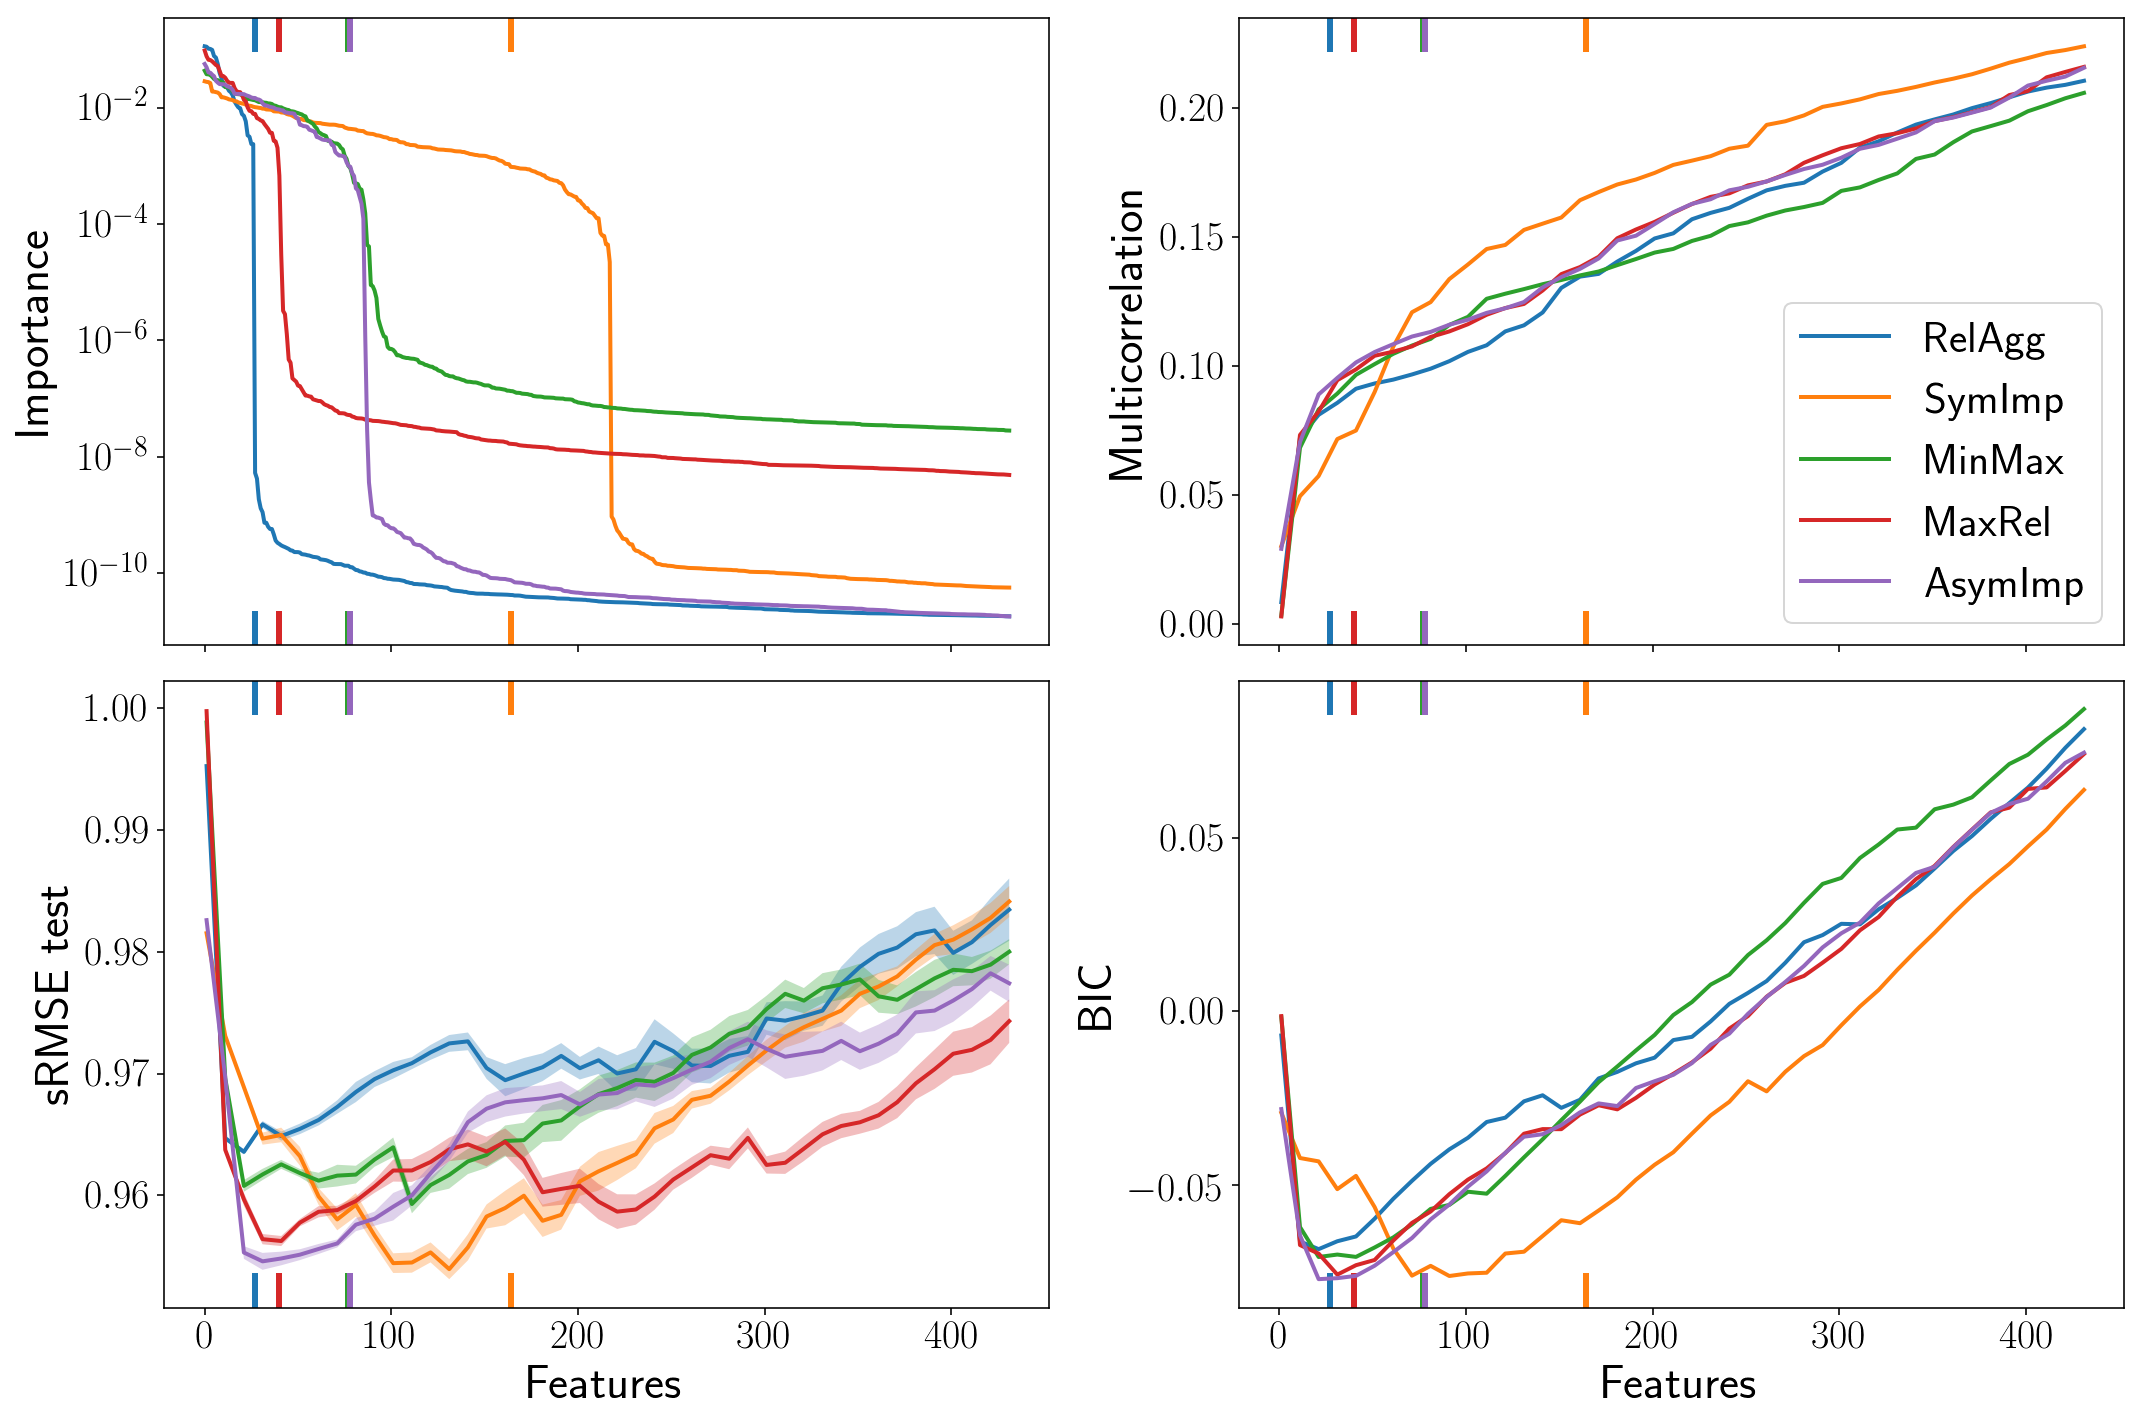

In [13]:
plot_metrics(agg_results)

# TABLE

In [33]:
steps = [30]
n_restarts = 5

for step in steps:
    Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
    Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0] - step + 1], Xtest[:Xtest.shape[0] - step + 1]

    print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)
    
    for i in tqdm_notebook(range(n_restarts), total=n_restarts):
        X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
        
        qpfs.fit(X, Y)
        
        score_history = [qpfs.zx.tolist()]
    
        mqpfs.get_params(X, Y)
        for mode in modes[1:]:
            alphas = mqpfs.get_alpha(mode)
            mqpfs.solve_problem(alphas, mode)
            score_history.append(mqpfs.zx.tolist())

        with open('res/mqpfs_scores_ecog_3_{}_bootstrap_{}.json'.format(step, i), 'w') as f:
            f.write(json.dumps(score_history))

(12772, 90) (12772, 864) (6058, 90) (6058, 864)


A Jupyter Widget

In [38]:
from itertools import combinations

step = 30
n_restarts = 5

modes = ['RelAgg', 'SymImp', 'MinMax', 'MaxMin', 'MaxRel', 'AsymImp']

score_history = []
for i in range(n_restarts):
    with open('res/mqpfs_scores_ecog_3_{}_bootstrap_{}.json'.format(step, i), 'r') as f:
        score_history.append(json.loads(f.read()))
        
Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0] - step + 1], Xtest[:Xtest.shape[0] - step + 1]

for i in range(6):
    print(modes[i])
    sh = [np.array(s[i])[:n_features] for s in score_history]
    corrs = []
    l2s = []
    l1s = []
    comps = []
    hams = []
    rmse = []
    for s1, s2 in combinations(sh, 2):
        corrs.append(sc.stats.spearmanr(s1, s2)[0])
        l2s.append(np.sqrt(np.sum((s1 - s2) ** 2)))
        l1s.append(np.sum(np.abs(s1 - s2)))
        hams.append(sc.spatial.distance.hamming(s1 > 1e-3, s2 > 1e-3))
        
    for s1 in sh:
        comps.append(np.sum(s1 > 1e-6))
        active_idxs = s1.argsort()[::-1][:50]#[:np.sum(s1 > 1e-3)]
        lr.fit(Xtrain_ar[:, active_idxs], Ytrain_ar)
        rmse.append(metric_rmse(Xtest_ar[:, active_idxs], Ytest_ar, lr))

    mean_corr = np.mean(corrs)
    std_corr = np.std(corrs)
    
    mean_l2 = np.mean(l2s)
    std_l2 = np.std(l2s)
    
    mean_l1 = np.mean(l1s)
    std_l1 = np.std(l1s)
    
    mean_comp = np.mean(comps)
    std_comp = np.std(comps)
    
    mean_ham = np.mean(hams)
    std_ham = np.std(hams)
    
    mean_rmse = np.mean(rmse)
    std_rmse = np.std(rmse)
    
    print(f'corr {mean_corr:.3f} $\pm$ {std_corr:.3f}')
    print(f'l2 {mean_l2:.3f} $\pm$ {std_l2:.3f}')
    print(f'l1 {mean_l1:.3f} $\pm$ {std_l1:.3f}')
    print(f'comp {mean_comp:.1f} $\pm$ {std_comp:.1f}')
    print(f'ham {mean_ham:.3f} $\pm$ {std_ham:.3f}')
    print(f'rmse {mean_rmse:.3f} $\pm$ {std_rmse:.3f}')
    print('-' * 80)

RelAgg
corr 0.915 $\pm$ 0.016
l2 0.145 $\pm$ 0.018
l1 0.648 $\pm$ 0.071
comp 26.8 $\pm$ 3.8
ham 0.025 $\pm$ 0.003
rmse 0.965 $\pm$ 0.002
--------------------------------------------------------------------------------
SymImp
corr 0.910 $\pm$ 0.017
l2 0.025 $\pm$ 0.002
l1 0.306 $\pm$ 0.024
comp 224.4 $\pm$ 9.0
ham 0.079 $\pm$ 0.007
rmse 0.961 $\pm$ 0.001
--------------------------------------------------------------------------------
MinMax
corr 0.932 $\pm$ 0.009
l2 0.059 $\pm$ 0.004
l1 0.493 $\pm$ 0.033
comp 101.0 $\pm$ 2.1
ham 0.041 $\pm$ 0.004
rmse 0.961 $\pm$ 0.002
--------------------------------------------------------------------------------
MaxMin
corr 0.903 $\pm$ 0.015
l2 0.091 $\pm$ 0.008
l1 0.734 $\pm$ 0.065
comp 95.2 $\pm$ 5.8
ham 0.055 $\pm$ 0.007
rmse 0.960 $\pm$ 0.002
--------------------------------------------------------------------------------
MaxRel
corr 0.862 $\pm$ 0.027
l2 0.178 $\pm$ 0.010
l1 1.014 $\pm$ 0.070
comp 41.2 $\pm$ 5.2
ham 0.042 $\pm$ 0.004
rmse 0.958 $

In [34]:
step = 30
n_restarts = 5

Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0] - step + 1], Xtest[:Xtest.shape[0] - step + 1]

rmse = []
for k in tqdm_notebook(range(1, 40)):
    pls = PLSRegression(n_components=k)
    tr = []
    te = []
    for i in range(n_restarts):
        X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
        pls.fit(X, Y)
        tr.append(metric_nmse(X, Y, pls))
        te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
    rmse.append((k, tr, te))
    
with open('res/pls_vs_k.json', 'w') as f:
    f.write(json.dumps(rmse))

A Jupyter Widget

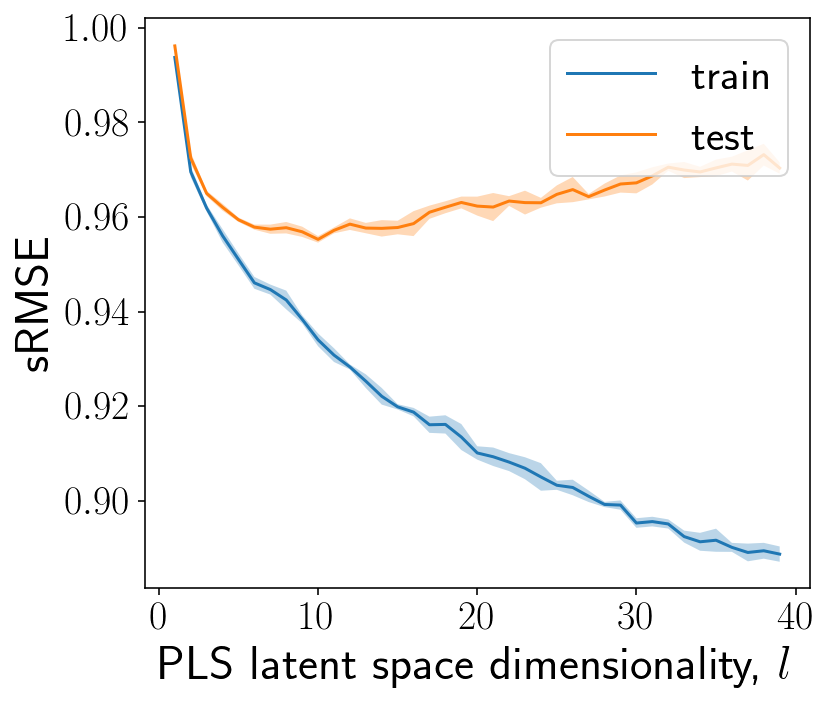

In [115]:
with open('res/pls_vs_k.json', 'r') as f:
    rmse = json.loads(f.read())

x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])

plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)

plt.ylabel(r'sRMSE')
plt.xlabel(r'PLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('figs/pls_vs_k.pdf', format='pdf')
plt.show()

In [12]:
step = 30

Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0] - step + 1], Xtest[:Xtest.shape[0] - step + 1]

mqpfs.fit(Xtrain_ar, Ytrain_ar, mode='AsymImp')
score = mqpfs.zx

In [ ]:
idxs_sort = score.argsort()[::-1]

rmse = []
n_feat_array = np.arange(50, n_features, 40)
n_comp_array = np.arange(1, 40, 2)

for n_feat in tqdm_notebook(n_feat_array):
    for k in n_comp_array:
        pls = PLSRegression(n_components=k)
        active_idxs = idxs_sort[:n_feat]
        pls.fit(Xtrain_ar[:, active_idxs], Ytrain_ar)
        rmse.append((n_feat, k, metric_nmse(Xtest_ar[:, active_idxs], Ytest_ar, pls)))

In [13]:
k = 15
n_feat = 100
n_restarts = 10

idxs_sort = score.argsort()[::-1]

rmse_lr = []
rmse_pls = []
rmse_lr_qpfs = []
rmse_pls_qpfs = []
rmse_mten = []
rmse_mten_qpfs = []
rmse_mtlasso = []
rmse_mtlasso_qpfs = []

pls = PLSRegression(n_components=k)
active_idxs = idxs_sort[:n_feat]

for i in range(n_restarts):
    X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
    
    mten.fit(X[:, active_idxs], Y)
    rmse_mten_qpfs.append(metric_nmse(Xtest_ar[:, active_idxs], Ytest_ar, mten))
    
    mten.fit(X, Y)
    rmse_mten.append(metric_nmse(Xtest_ar, Ytest_ar, mten))
    
    mtlasso.fit(X[:, active_idxs], Y)
    rmse_mtlasso_qpfs.append(metric_nmse(Xtest_ar[:, active_idxs], Ytest_ar, mtlasso))
    
    mtlasso.fit(X, Y)
    rmse_mtlasso.append(metric_nmse(Xtest_ar, Ytest_ar, mtlasso))
    
    pls.fit(X[:, active_idxs], Y)
    rmse_pls_qpfs.append(metric_nmse(Xtest_ar[:, active_idxs], Ytest_ar, pls))
    
    lr.fit(X[:, active_idxs], Y)
    rmse_lr_qpfs.append(metric_nmse(Xtest_ar[:, active_idxs], Ytest_ar, lr))
    
    pls.fit(X, Y)
    rmse_pls.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
    
    lr.fit(X, Y)
    rmse_lr.append(metric_nmse(Xtest_ar, Ytest_ar, lr))
    
    print(f'{i} finished')
    
print('{:.4f} \pm {:.4f}'.format(np.mean(rmse_lr), np.std(rmse_lr)))
print('{:.4f} \pm {:.4f}'.format(np.mean(rmse_lr_qpfs), np.std(rmse_lr_qpfs)))
print('{:.4f} \pm {:.4f}'.format(np.mean(rmse_pls), np.std(rmse_pls)))
print('{:.4f} \pm {:.4f}'.format(np.mean(rmse_pls_qpfs), np.std(rmse_pls_qpfs)))

print('{:.4f} \pm {:.4f}'.format(np.mean(rmse_mten), np.std(rmse_mten)))
print('{:.4f} \pm {:.4f}'.format(np.mean(rmse_mten_qpfs), np.std(rmse_mten_qpfs)))
print('{:.4f} \pm {:.4f}'.format(np.mean(rmse_mtlasso), np.std(rmse_mtlasso)))
print('{:.4f} \pm {:.4f}'.format(np.mean(rmse_mtlasso_qpfs), np.std(rmse_mtlasso_qpfs)))

0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
1.0260 \pm 0.0036
0.9593 \pm 0.0018
0.9580 \pm 0.0019
0.9562 \pm 0.0017
0.9476 \pm 0.0013
0.9547 \pm 0.0011
0.9476 \pm 0.0010
0.9550 \pm 0.0010


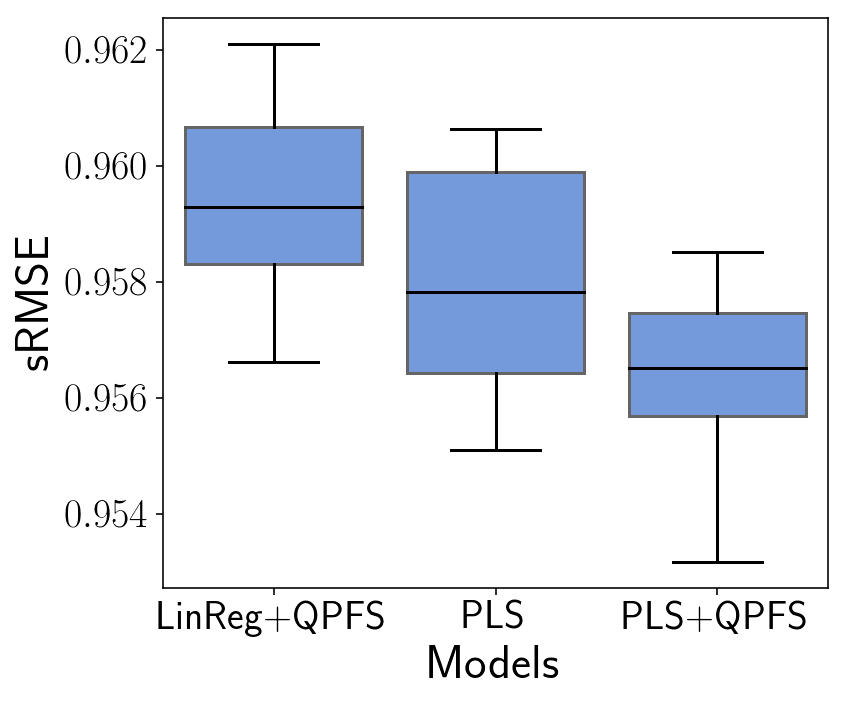

In [14]:
import pandas as pd

df = pd.DataFrame([*rmse_lr_qpfs, *rmse_pls, *rmse_pls_qpfs], columns=['sRMSE'])
df['model'] = ['LinReg+QPFS'] * n_restarts + ['PLS'] * n_restarts + ['PLS+QPFS'] * n_restarts

plt.figure(figsize=(6, 5))
ax = sns.boxplot(x="model", y="sRMSE", data=df, color='cornflowerblue', showfliers=False)
ax.set_xlabel('Models')
plt.setp(ax.lines, color='k')
plt.tight_layout()
plt.savefig('figs/models.eps', format='eps')
plt.show()

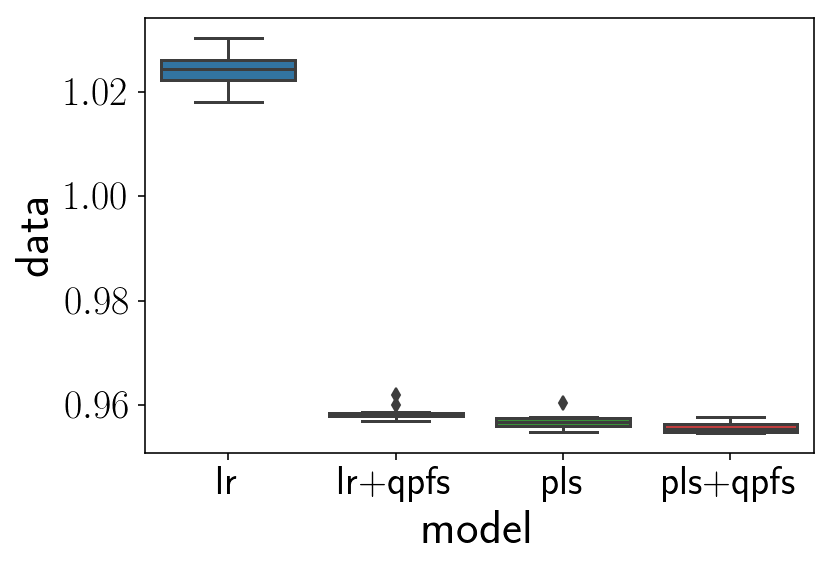